## DEMO: **XGBOOST REGRESSION**


In [31]:
# Thư viện
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import xgboost as xgb

---
### **Môi trường triển khai ứng dụng**
---

In [16]:
# Đọc dữ liệu
df = pd.read_csv(r"C:\Users\ASUS\Documents\PPNC---Comparing-Machine-Learning-Models-for-AQI-Prediction-in-HCMC\Data\DATASET_state_weather_aqi_data_PPNC.csv")

---
### **Định nghĩa hàm tính RMSLE**
---

In [17]:
# Định nghĩa hàm tính RMSLE
def rmsle(real, predicted):
    sum = 0.0
    real = np.ravel(real) if hasattr(real, 'shape') and len(real.shape) > 1 else real
    predicted = np.ravel(predicted) if hasattr(predicted, 'shape') and len(predicted.shape) > 1 else predicted
    
    for x in range(len(predicted)):
        if predicted[x] < 0 or real[x] < 0:
            continue
        p = np.log(predicted[x] + 1)
        r = np.log(real[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

---
### **Xác định cột và giá trị**
---

In [18]:
# Xác định các cột cần dùng
categorical_features = ['City', 'district']  # Đặc trưng phân loại
numerical_features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE']  # Đặc trưng số
target = 'AQI'

# Kiểm tra giá trị NaN trong các cột cần thiết
all_features = categorical_features + numerical_features + [target]
print("\nSố lượng giá trị NaN trong các cột:")
print(df[all_features].isnull().sum())

# Loại bỏ các dòng có giá trị NaN trong các cột cần thiết
df_clean = df.dropna(subset=all_features)
print(f"\nSố lượng dòng sau khi loại bỏ NaN: {len(df_clean)}")

# One-hot encoding cho các đặc trưng phân loại
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = ohe.fit_transform(df_clean[categorical_features])
categorical_df = pd.DataFrame(
    categorical_data, 
    columns=ohe.get_feature_names_out(categorical_features)
)

# Kết hợp các đặc trưng đã mã hóa và đặc trưng số
feature_set = pd.concat([categorical_df.reset_index(drop=True), 
                         df_clean[numerical_features].reset_index(drop=True)], axis=1)
y = df_clean[target].values

print(f"Kích thước feature_set: {feature_set.shape}")
print(f"Kích thước y: {y.shape}")



Số lượng giá trị NaN trong các cột:
City          0
district      0
PM2.5       173
PM10        337
NO2         155
NH3         444
SO2         213
CO           63
OZONE       149
AQI           0
dtype: int64

Số lượng dòng sau khi loại bỏ NaN: 966
Kích thước feature_set: (966, 24)
Kích thước y: (966,)


---
## **PHẦN 1: Đánh giá mô hình SVR dựa trên AQI**
---

In [19]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.25, random_state=0)

In [20]:
# Huấn luyện và đánh giá mô hình XGBoost
print("\nHuấn luyện mô hình XGBoost...")

# Khởi tạo và huấn luyện mô hình XGBoost
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0
)
xgb_reg.fit(X_train, y_train)

# Dự đoán trên tập huấn luyện và kiểm tra
xgb_train_predict = xgb_reg.predict(X_train)
xgb_y_predict = xgb_reg.predict(X_test)


Huấn luyện mô hình XGBoost...


In [21]:
# Đánh giá các mô hình trên tập huấn luyện
xgb_ytp_r2 = float(r2_score(y_train, xgb_train_predict))
xgb_ytp_rmse = float(sqrt(mean_squared_error(y_train, xgb_train_predict)))
xgb_ytp_mae = float(mean_absolute_error(y_train, xgb_train_predict))
xgb_ytp_rmsle = float(rmsle(y_train, xgb_train_predict))
xgb_ytp_mse = float(mean_squared_error(y_train, xgb_train_predict))

# Đánh giá các mô hình trên tập kiểm tra
r2_xgb = float(r2_score(y_test, xgb_y_predict))
rmse_xgb = float(sqrt(mean_squared_error(y_test, xgb_y_predict)))
mae_xgb = float(mean_absolute_error(y_test, xgb_y_predict))
rmsle_xgb = float(rmsle(y_test, xgb_y_predict))
mse_xgb = float(mean_squared_error(y_test, xgb_y_predict))

In [22]:
# Hiển thị kết quả
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("XGBoost\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(xgb_ytp_r2, xgb_ytp_rmse, xgb_ytp_mae, xgb_ytp_rmsle, xgb_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("XGBoost\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_xgb, rmse_xgb, mae_xgb, rmsle_xgb, mse_xgb))


Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
XGBoost	0.9995	2.2351	1.7242	0.0196	4.9957

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
XGBoost	0.9913	8.7119	5.7722	0.0598	75.8968


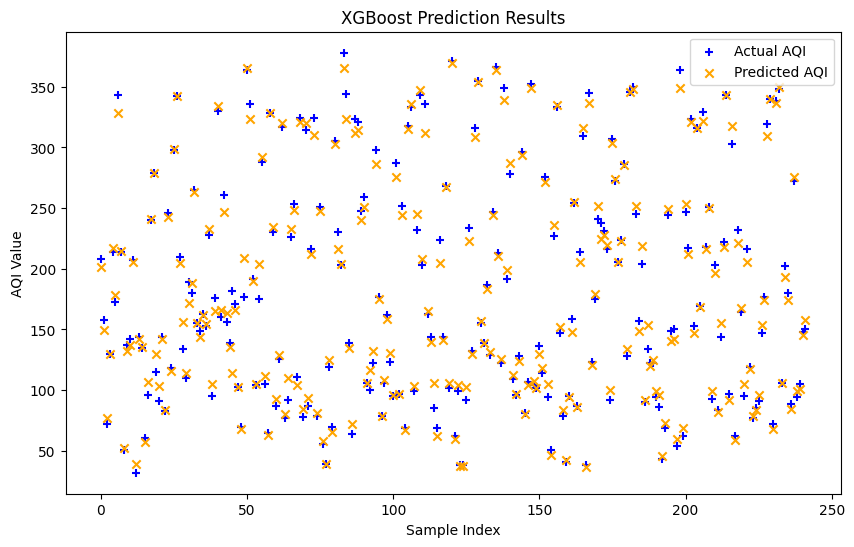

In [23]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(xgb_y_predict)), xgb_y_predict, c='orange', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('XGBoost Prediction Results')
plt.legend()
plt.savefig('xgboost_prediction_results.png', dpi=300)
plt.show()

---
## **PHẦN 2: Đánh giá mô hình SVR dựa trên các chỉ số R2, RMSE, MAE, RMLE**
---

In [24]:
# Danh sách lưu kết quả
r2_list, rmse_list, mae_list, mse_list, rmsle_list = [], [], [], [], []

In [25]:
# Train 20 lần với XGBoost
print("\nHuấn luyện mô hình XGBoost 20 lần...")
for i in range(20):
    print(f"Vòng {i+1}/20...")
    
    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra với random_state khác nhau
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.25, random_state=i)
    
    # Huấn luyện mô hình XGBoost
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=i
    )
    xgb_reg.fit(X_train, y_train)
    
    # Dự đoán kết quả trên tập kiểm tra
    xgb_y_predict = xgb_reg.predict(X_test)
    
    # Tính các chỉ số đánh giá
    r2 = r2_score(y_test, xgb_y_predict)
    rmse = sqrt(mean_squared_error(y_test, xgb_y_predict))
    mae = mean_absolute_error(y_test, xgb_y_predict)
    mse = mean_squared_error(y_test, xgb_y_predict)
    rmsle_val = rmsle(y_test, xgb_y_predict)
    
    # Lưu kết quả vào các danh sách
    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse)
    rmsle_list.append(rmsle_val)


Huấn luyện mô hình XGBoost 20 lần...
Vòng 1/20...
Vòng 2/20...
Vòng 3/20...
Vòng 4/20...
Vòng 5/20...
Vòng 6/20...
Vòng 7/20...
Vòng 8/20...
Vòng 9/20...
Vòng 10/20...
Vòng 11/20...
Vòng 12/20...
Vòng 13/20...
Vòng 14/20...
Vòng 15/20...
Vòng 16/20...
Vòng 17/20...
Vòng 18/20...
Vòng 19/20...
Vòng 20/20...


In [26]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [27]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9965
RMSE trung bình: 5.5800
MAE trung bình: 3.7917
MSE trung bình: 33.2921
RMSLE trung bình: 0.0395


In [28]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_xgboost.csv', index=False)

---
## **XGBoost Regression Model**
---

Đã lưu biểu đồ vào file 'metrics_per_round_xgboost.png'


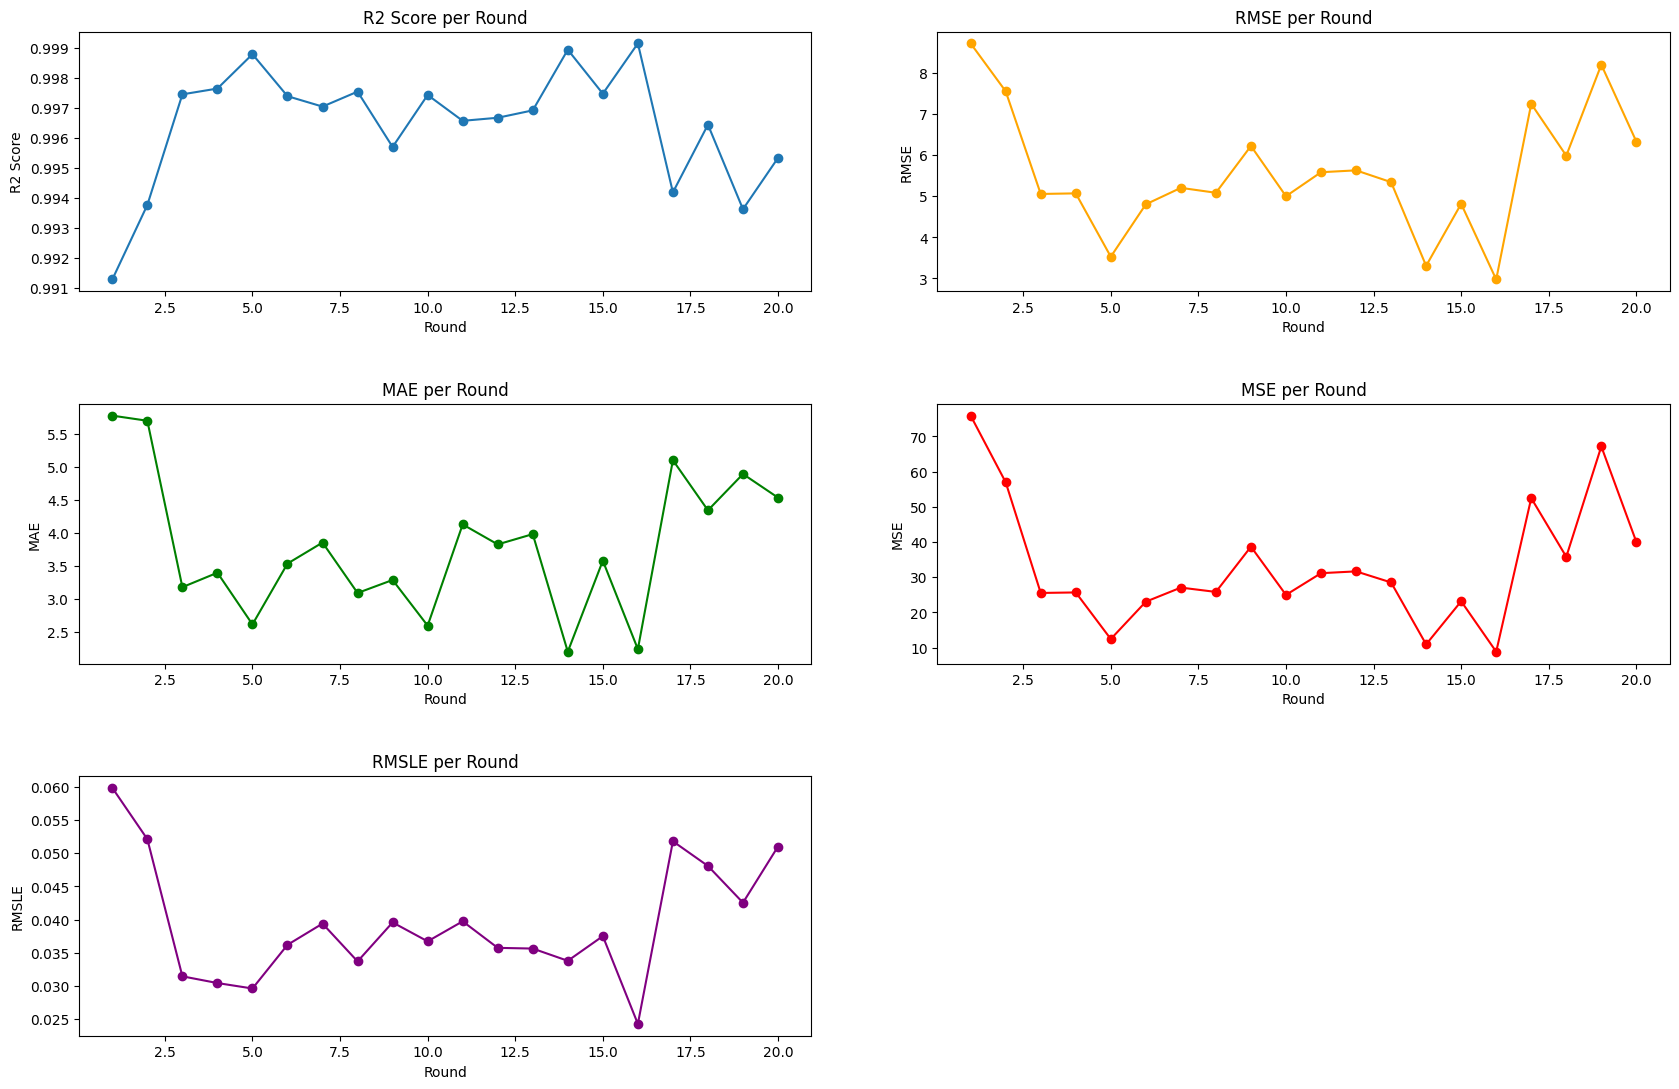

Đã lưu biểu đồ tính năng quan trọng vào file 'xgboost_feature_importance.png'


<Figure size 1200x600 with 0 Axes>

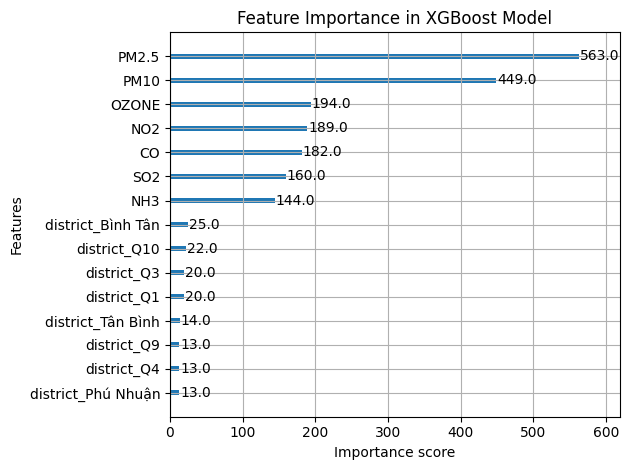

In [29]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_xgboost.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_xgboost.png'")
plt.show()

# Thêm phần so sánh tính năng quan trọng (Feature Importance)
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_reg, max_num_features=15)
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=300)
print("Đã lưu biểu đồ tính năng quan trọng vào file 'xgboost_feature_importance.png'")
plt.show()